In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.combine import SMOTETomek
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot
from matplotlib.pyplot import figure
from numpy import argmax


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
orders = pd.read_excel('orders.xlsx')

In [3]:
orders.dtypes

order_id                              object
customer_id                           object
merchant_id                           object
order_amount                         float64
checkout_started_at           datetime64[ns]
credit_decision_started_at    datetime64[ns]
approved_for_installments               bool
customer_credit_score                  int64
customer_age                           int64
customer_billing_zip                  object
customer_shipping_zip                 object
paid_installment_1                   float64
paid_installment_2                     int64
paid_installment_3                   float64
paid_installment_4                   float64
dtype: object

In [4]:
orders.describe().T

,count,mean,std,min,25%,50%,75%,max
order_amount,10000.0,146.252272,167.883106,4.95,64.0,90.765,155.00,1936.0
customer_credit_score,10000.0,613.435900,92.555118,1.00,562.0,611.000,664.00,836.0
customer_age,10000.0,33.544300,11.933729,18.00,24.0,30.000,40.25,89.0
paid_installment_1,9998.0,1.000000,0.000000,1.00,1.0,1.000,1.00,1.0
paid_installment_2,10000.0,0.977900,0.147016,0.00,1.0,1.000,1.00,1.0
paid_installment_3,9996.0,0.959684,0.196709,0.00,1.0,1.000,1.00,1.0
paid_installment_4,9423.0,0.940359,0.236834,0.00,1.0,1.000,1.00,1.0


##       Checking and treating outliers with Z-score treatment

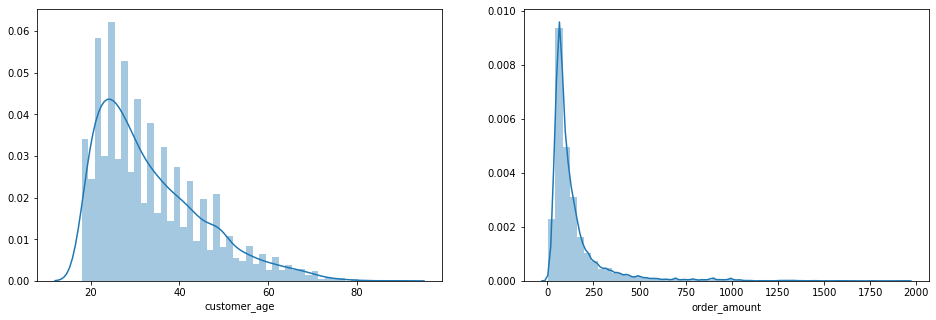

In [5]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.distplot(orders['customer_age'])
plt.subplot(1,2,2)
sns.distplot(orders['order_amount'])
plt.show()

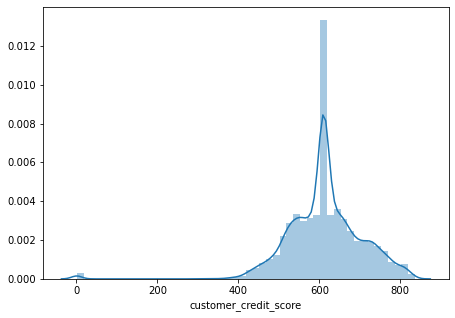

In [6]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.distplot(orders['customer_credit_score'])
plt.show()

There are few outliers in <b> Customer_Credit_score</b> and there value is 1. We will be limiting them with mean +/- 3 standard Deviation

In [7]:
# Z-score treatment
Highest_limit = orders['customer_credit_score'].mean() + 3*orders['customer_credit_score'].std()
Lowest_limit = orders['customer_credit_score'].mean() - 3*orders['customer_credit_score'].std()
print("Lower Limit :{}      Higher Limit: {}".format(Lowest_limit,Highest_limit))

orders = orders[(orders['customer_credit_score'] > Lowest_limit) & (orders['customer_credit_score'] < Highest_limit)]

Lower Limit :335.77054489487784      Higher Limit: 891.101255105122


# ---------------------------------------------------------------------------------------------------------------

## Missing Value Treatment

In [8]:
null_columns = orders.columns[orders.isnull().any()]
orders[null_columns].isnull().sum()

customer_billing_zip      11
customer_shipping_zip     23
paid_installment_1         2
paid_installment_3         4
paid_installment_4       576
dtype: int64

In [9]:
# replacing the Zip values with most frequent repeated Items, we dont want to loose the record as zip codes are not relevant feature
# for modeling .

orders['customer_billing_zip'].fillna(orders['customer_billing_zip'].mode()[0], inplace = True)
orders['customer_shipping_zip'].fillna(orders['customer_shipping_zip'].mode()[0], inplace = True)
orders = orders.dropna()

In [10]:
len(orders)

9367

### --------------------------------------------------------------------------------------------------------------------------------------------------------------

### <b> Logic behind Target Variable <br><br></b>
    
Since our aim is to identify transactions which can be defaulted in future Payments<br><br>
If a Customer has made all payments (all 1's) , Default status will be 0<br>
If a Customer fas missed even a single payment, Default status will be 1
    
    

In [11]:
orders['Total_Installment_paid'] = orders['paid_installment_1'] + orders['paid_installment_2'] +orders['paid_installment_3'] + orders['paid_installment_4']

orders['Default_status']  = np.where(orders['Total_Installment_paid'] == 4, 0, 1)
pd.crosstab(orders['Default_status'],orders['Total_Installment_paid'] )

Total_Installment_paid,1.0,2.0,3.0,4.0
Default_status,,,,
0,0,0,0,8703
1,140,203,321,0


### _______                                                                Adding an additional feature 
If the Customer has defualted any previous payment before current payment, the column value will be True.
<br>If The customer has not defaulted previously or making their first order, The value will be False.  


In [12]:
#Creating a seperate dataframe for customers who defaulted any EMI

EMI_defaulters = orders[(orders['Default_status']==1)]
EMI_defaulters = EMI_defaulters[['customer_id','checkout_started_at','Default_status']]
EMI_defaulters = EMI_defaulters.sort_values(by=['customer_id', 'checkout_started_at'])

EMI_defaulters = EMI_defaulters.drop_duplicates(subset=['customer_id', 'checkout_started_at'], keep='first')

EMI_defaulters.rename(columns={'Default_status': 'Previously_Defaulted','checkout_started_at': 'previous_date'}, inplace=True)

# Joining it back to the Main Orders Table
orders_data = pd.merge(orders, EMI_defaulters, how='left', on=['customer_id'])

orders_data['Previously_Defaulted'] = orders_data['Previously_Defaulted'].fillna(0)

# dedupping step
orders_data_0 =  orders_data[(orders_data['order_id'] == 0)] # since there are 6 records with same order-id i.e. 0
orders_data_0_default =  orders_data[(orders_data['order_id'] != 0)& (orders_data['Previously_Defaulted'] == 0)] # Not matched ones
orders_data_1_default =orders_data[(orders_data['checkout_started_at'] > orders_data['previous_date']) | (orders_data['Previously_Defaulted'] ==1) ]
orders_data_1_default= orders_data_1_default.drop_duplicates(subset=['order_id','customer_id'], keep='first')

len(orders_data_1_default)

#Combining all three 
orders_data_new = pd.concat([orders_data_1_default, orders_data_0_default,orders_data_0], ignore_index=True)
orders_data_new['Previously_Defaulted']  = np.where((orders_data_new['checkout_started_at'] == orders_data_new['previous_date']), 0, orders_data_new['Previously_Defaulted'] )



# convertig to Boolean
orders_data_new['Previously_Defaulted'] = orders_data_new['Previously_Defaulted'].astype('bool')

orders_data_new['Previously_Defaulted'].value_counts()
orders_data_new.reset_index(inplace = True, drop = True)

In [13]:
X_orders = orders_data_new[['order_amount','customer_credit_score', 'customer_age','Previously_Defaulted']]
Y_orders = orders_data_new['Default_status']

scaler = StandardScaler()
X_orders = scaler.fit_transform(X_orders)

### SmoteTomek for Class Imbalance <br>

Oversampling to overcome Class imbalance only on Train data, so that we can correctly classify the minoity class( i.e. 1 Default)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_orders, Y_orders, test_size=0.3, random_state = 123) # 70% training and 30% test


# Uversampling the Imbalanced data with SmoteTomek
smtm = SMOTETomek(random_state = 122)
X_train_smtm, y_train_smtm = smtm.fit_resample(X_train, y_train)

### Creating Logistic Regression model with 70 % Train data 

In [15]:
# Create and fit a logistic regression model
log_reg = LogisticRegression(solver='lbfgs')
log_reg.fit(X_train_smtm, np.ravel(y_train_smtm))

# Print the parameters of the model
#print(log_reg.get_params())

# Print the intercept of the model
print(log_reg.intercept_)

# Print the models coefficients
print(log_reg.coef_)


log_reg.score(X_test,y_test)

[-0.43523295]
[[ 0.16232421 -0.98400628 -0.29638464  0.28357129]]


0.712557808609036

In [16]:
predictions = log_reg.predict(X_test)
predictions = pd.DataFrame(predictions, columns = ['Predicted_Default'])
y_test.reset_index(inplace = True, drop = True)
y_test  = pd.DataFrame(y_test, columns=['Default_status'])


In [17]:
# Accuracy and Confusion Matrix

predicted = predictions['Predicted_Default']
actual = y_test['Default_status']


# confusion matrix
matrix = confusion_matrix(actual,predicted, labels=[1,0])
print('Confusion matrix : \n',matrix)

# outcome values order in sklearn
tp, fn, fp, tn = confusion_matrix(actual,predicted,labels=[1,0]).reshape(-1)
print('Outcome values : ', tp, fn, fp, tn)


# classification report for precision, recall f1-score and accuracy
#target_names = ['Non-Default', 'Default']
matrix = classification_report(actual,predicted, labels=[1,0])
print('\nClassification report : \n',matrix)


sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp) 
accuracy = (tp + tn)/(tp + fn + fp + tn)
print('\nOverall accuracy :',accuracy)
print('\nSensitivity      :',sensitivity)
print('\nSpecificity      :',specificity)



Confusion matrix : 
 [[ 120   74]
 [ 734 1883]]
Outcome values :  120 74 734 1883

Classification report : 
               precision    recall  f1-score   support

           1       0.14      0.62      0.23       194
           0       0.96      0.72      0.82      2617

    accuracy                           0.71      2811
   macro avg       0.55      0.67      0.53      2811
weighted avg       0.91      0.71      0.78      2811


Overall accuracy : 0.712557808609036

Sensitivity      : 0.6185567010309279

Specificity      : 0.719526175009553


<b> <u> Logistic Regression Model has a accuracy of 72.5 % on default probability cutoff of 0.5<br> <br>
True Positive rate or Recall(1) is 60%, i.e. that is we are able to precict 60 % defaults.<br>   
We can adjsust threshold and see if we can increase the recall (1).

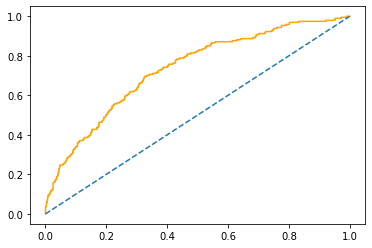

The Accuracy on default cutoff is :  0.712557808609036
The AUC value for cutoff is :  0.7324817115686886


In [18]:
# Create predictions and store them in a variable
preds = log_reg.predict_proba(X_test)

# Plot the ROC curve of the probabilities of default
prob_default = preds[:, 1]
prediction_default = pd.DataFrame(prob_default, columns=['Default_Prob'])

fallout, sensitivity, thresholds = roc_curve(y_test, prob_default)
plt.plot(fallout, sensitivity, color = 'orange')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show()

# Compute the AUC and store it in a variable
auc = roc_auc_score(y_test, prob_default)

# Print the accuracy score the model
print("The Accuracy on default cutoff is : ",log_reg.score(X_test, y_test))
print("The AUC value for cutoff is : ",auc)

Best Threshold=0.474944, G-Mean=0.685


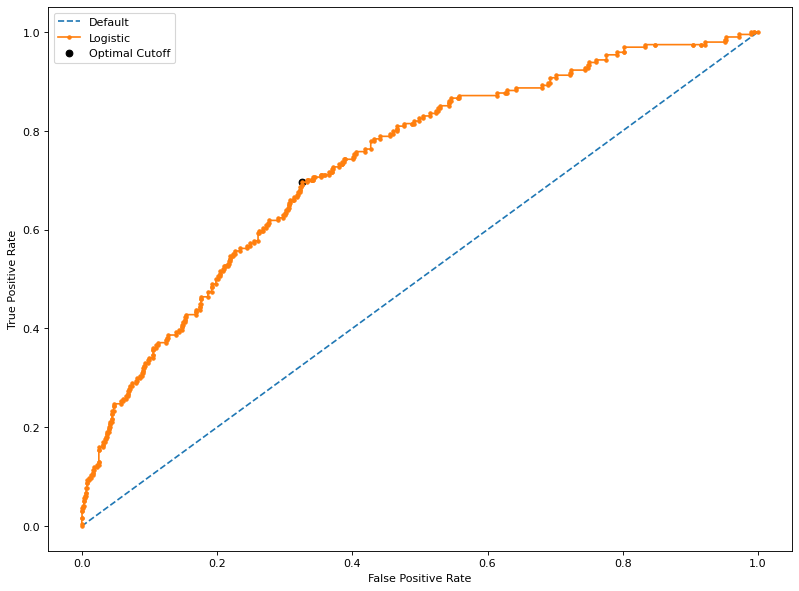

In [19]:

# calculate the g-mean for each threshold
gmeans = np.sqrt(sensitivity * (1-fallout)) #fallout, sensitivity
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

figure(figsize=(12, 9), dpi=80)
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='Default')
pyplot.plot(fallout, sensitivity, marker='.', label='Logistic')
pyplot.scatter(fallout[ix], sensitivity[ix], marker='o', color='black', label='Optimal Cutoff')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

In [20]:
# Reassign the values of loan status based on the new threshold
prediction_default['Default_status'] = prediction_default['Default_Prob'].apply(lambda x: 1 if x > 0.47 else 0)

# Store the number of loan defaults from the prediction data
prediction_default['Default_status'].value_counts()

predicted = prediction_default['Default_status']
#predictions['Predicted_Default'].value_counts()

# Store the default recall from the classification report
default_recall = precision_recall_fscore_support(y_test,prediction_default['Default_status'])[1][1]
print(default_recall)

#avg_loan_amnt = 57
# Calculate the estimated impact of the new default recall rate
#print(num_defaults * avg_loan_amnt * (1 - default_recall))

matrix = classification_report(actual,predicted, labels=[1,0])
print('\nClassification report : \n',matrix)


# outcome values order in sklearn
tp, fn, fp, tn = confusion_matrix(actual,predicted,labels=[1,0]).reshape(-1)
print('Outcome values : ', tp, fn, fp, tn)



sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp) 
accuracy = (tp + tn)/(tp + fn + fp + tn)
print('\nOverall accuracy :',accuracy)
print('\nSensitivity      :',sensitivity)
print('\nSpecificity      :',specificity)


#print(num_defaults * avg_loan_amnt * (1 - default_recall))

0.7061855670103093

Classification report : 
               precision    recall  f1-score   support

           1       0.13      0.71      0.22       194
           0       0.97      0.65      0.78      2617

    accuracy                           0.66      2811
   macro avg       0.55      0.68      0.50      2811
weighted avg       0.91      0.66      0.74      2811

Outcome values :  137 57 903 1714

Overall accuracy : 0.6584845250800427

Sensitivity      : 0.7061855670103093

Specificity      : 0.6549484142147497


<b> <font color='blue'> Applying the Optimal Threshold of 0.47 and Re calculating the predictions, The Recall (1) has increased to 70.7 % <br><br>
Our Model accuracy has reduced to 64 % , which is acceptable because our aim to predict default events more accurately than the non default events.    </font>

###                                                           XGboost Model

In [21]:
X_train_smtm = pd.DataFrame(X_train_smtm, columns=['order_amount','customer_credit_score', 'customer_age','Previously_Defaulted'])

xgb_model=xgb.XGBClassifier(colsample_bytree = 0.3, gamma = 0.2, learning_rate = 0.2, max_depth = 10)
xgb_model.fit(X_train_smtm,y_train_smtm.values.ravel())
y_pred=xgb_model.predict(X_test)
XGB_accuracy= metrics.accuracy_score(y_test, y_pred)
#log_reg.fit(X_train_smtm, np.ravel(y_train_smtm))
print("\n\n XGboost Model Accuracy : {}".format(XGB_accuracy))

[01:43:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 XGboost Model Accuracy : 0.8900747065101388


In [22]:
# Accuracy and Confusion Matrix

predicted = y_pred
actual = y_test


# confusion matrix
matrix = confusion_matrix(actual,predicted, labels=[1,0])
print('Confusion matrix : \n',matrix)

# outcome values order in sklearn
tp, fn, fp, tn = confusion_matrix(actual,predicted,labels=[1,0]).reshape(-1)
print('Outcome values : ', tp, fn, fp, tn)


# classification report for precision, recall f1-score and accuracy
matrix = classification_report(actual,predicted, labels=[1,0])
print('\nClassification report : \n',matrix)


sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp) 
accuracy = (tp + tn)/(tp + fn + fp + tn)
print('\nOverall accuracy :',accuracy)
print('\nSensitivity      :',sensitivity)
print('\nSpecificity      :',specificity)


Confusion matrix : 
 [[  31  163]
 [ 146 2471]]
Outcome values :  31 163 146 2471

Classification report : 
               precision    recall  f1-score   support

           1       0.18      0.16      0.17       194
           0       0.94      0.94      0.94      2617

    accuracy                           0.89      2811
   macro avg       0.56      0.55      0.55      2811
weighted avg       0.89      0.89      0.89      2811


Overall accuracy : 0.8900747065101388

Sensitivity      : 0.15979381443298968

Specificity      : 0.9442109285441345


<b>  with the XGBoost Modeling approach our accuracy has increased to 89% <br><br>
But our Recall(1) value is poor, Which means we are not able to predict default events correctly.<br><br>
    
So lets consider results from Logistic regression model as a reliable prediction model.   

In [23]:
# Create and train the model on the training data
#clf_gbt = xgb.XGBClassifier().fit(X_train,np.ravel(y_train))

# Print the column importances from the model
print(xgb_model.get_booster().get_score(importance_type = 'weight'))

{'order_amount': 2093, 'Previously_Defaulted': 21, 'customer_age': 773, 'customer_credit_score': 1923}


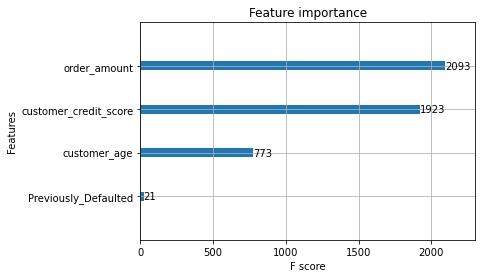

In [24]:
# Plot the column importance for this model
xgb.plot_importance(xgb_model, importance_type = 'weight')
plt.show()

In [25]:
print(671 * 145.66 * (1 - 0.7070))

28637.192980000003
